<a href="https://colab.research.google.com/github/Sungrebe/Smart-Bird-Feeder/blob/main/cc_backyard_bird_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install astrapy and sentence_transformers (run this every time the runtime restarts)
!pip install astrapy
!pip install transformers

import os
from PIL import Image
from matplotlib import pyplot as plt
from astrapy import DataAPIClient
from transformers import CLIPProcessor, CLIPModel
from google.colab import drive, userdata, files

# load database and image collection

client = DataAPIClient(userdata.get('ASTRA_DB_APPLICATION_TOKEN'))
db = client.get_database(userdata.get('ASTRA_DB_API_ENDPOINT'))
col = db.get_collection("cc_backyard_birds")

# load CLIP model (Vit-B-32)

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Helper method for the model to process image inputs
def process_image(image_path):
  input = processor(
    images=Image.open(image_path),
    return_tensors="pt"
  )
  return model.get_image_features(**input).flatten()

In [ ]:
# Hash table with select bird species (only 11 for testing purposes)
# and their image folders from the nabirds dataset
# in the final version we will have at least 100 species
species = {
    "Mourning Dove": ["0529"],
    "Red-bellied Woodpecker": ["0553"],
    "Blue Jay": ["0950"],
    "Black-capped Chickadee": ["0812"],
    "Tufted Titmouse": ["0819"],
    "European Starling": ["0748", "0856", "1005"],
    "American Robin": ["0753", "0960"],
    "House Finch": ["0790", "0997"],
    "American Goldfinch": ["0794", "1001"],
    "Common Grackle": ["0912"],
    "Northern Cardinal": ["0772", "0979"],
}

"""
# load cc_backyard_birds images into dataset

drive.mount('/content/drive')
nabirds_dir = "/content/drive/MyDrive/nabirds/"

for species_name, species_folders in species.items():
  for folder in species_folders:
    for img_file in os.listdir(nabirds_dir + folder):
      # convert each image into a vector representation using CLIP model
      img_vector = process_image(nabirds_dir + folder + "/" + img_file)

      col.insert_one({
          "text": species_name,
          "$vector": img_vector.tolist(),
      })
"""

In [ ]:
# TODO: implement fine-tuning algorithm

# We will use triplet loss

# Basic idea is that for each species, we create a set of triplets
# Each triplet consists of three images - an anchor, positive, and negative
# The anchor image is an image of the species, the positive another
# image of that species, and the negative an image of an unrelated but
# easily confused species (from the perspective of the model)

# 1. Create a dataset of triplets (~10 for each species to start with)

# 2. Split dataset into training, test, and validation

# 3. Define triplet loss function

# 4. Write a training loop
  # - Compute predicted outputs
  # - Get loss for each step
  # - Perform optimization
  # - Get val accuracy after each step

# 5. Save a copy of the fine tuned model

# 6. Create a new collection of images using the fine tuned model and
# perform image searches using that collection

Saving 640-12.jpg to 640-12.jpg


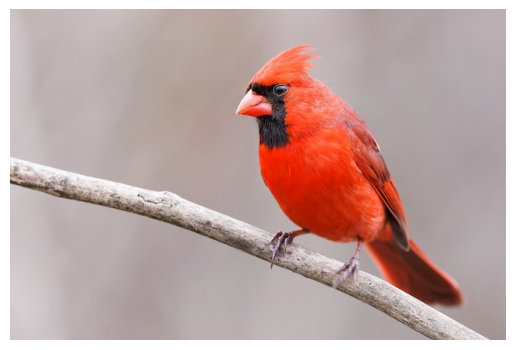

{'_id': '868b8855-96ad-40a1-8b88-5596ada0a1a0', 'text': 'Northern Cardinal', '$similarity': 0.9784504}
{'_id': '86d8a335-4468-464f-98a3-354468164f31', 'text': 'Northern Cardinal', '$similarity': 0.9774036}
{'_id': '23ff3375-8a89-4000-bf33-758a89b00099', 'text': 'Northern Cardinal', '$similarity': 0.97735906}
{'_id': 'ca99f0e1-6517-410a-99f0-e16517910a0c', 'text': 'Northern Cardinal', '$similarity': 0.9734572}
{'_id': 'e21b2c94-0e57-4452-9b2c-940e57e4527b', 'text': 'Northern Cardinal', '$similarity': 0.9733916}
{'_id': '421ec50c-53a2-4656-9ec5-0c53a26656a4', 'text': 'Northern Cardinal', '$similarity': 0.9732549}
{'_id': '5994c5e3-1a20-40cf-94c5-e31a20c0cfcf', 'text': 'Northern Cardinal', '$similarity': 0.97286224}
{'_id': '6283c221-6994-40d9-83c2-21699470d9fe', 'text': 'Northern Cardinal', '$similarity': 0.9728587}
{'_id': '5ba9beb1-036b-434e-a9be-b1036bf34ec3', 'text': 'Northern Cardinal', '$similarity': 0.97143036}
{'_id': '1d970ddc-cb3b-4662-970d-dccb3b8662e3', 'text': 'Northern Card

In [ ]:
# method for searching database
# returns top 15 most similar images given a specific image
async def search_img(image_path):
  searching_vector = process_image(image_path).tolist()
  most_similar_imgs = col.find(
      {},
      sort={"$vector": searching_vector},
      limit=15,
      include_similarity=True,
  )

  return most_similar_imgs

# demo code, loads a user inputted image and classifies it using the search_img method

images = files.upload()
input_path = next(iter(images))

plt.imshow(Image.open(input_path))
plt.axis("off")
plt.show()

results = await search_img(input_path)

for result in results:
  print(result)